<a href="https://colab.research.google.com/github/avgt93/ai-statespace-search/blob/master/cv_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [2]:
! chmod 600 ~/.kaggle.json

chmod: cannot access '/root/.kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

100% 191M/192M [00:09<00:00, 23.1MB/s]
100% 192M/192M [00:09<00:00, 21.2MB/s]


In [5]:
!unzip "landscape-image-colorization.zip"

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '4500.jpg':
        break
    else:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))

del files

gray_img = []
path = '/content/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '4500.jpg':
        break
     else:
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

del files

 63%|██████▎   | 4500/7129 [00:07<00:04, 623.54it/s] 


In [3]:
def plot_images_2(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)

    plt.show()

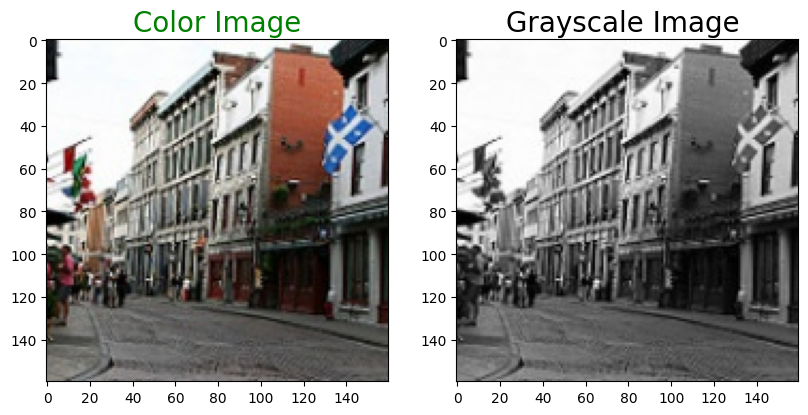

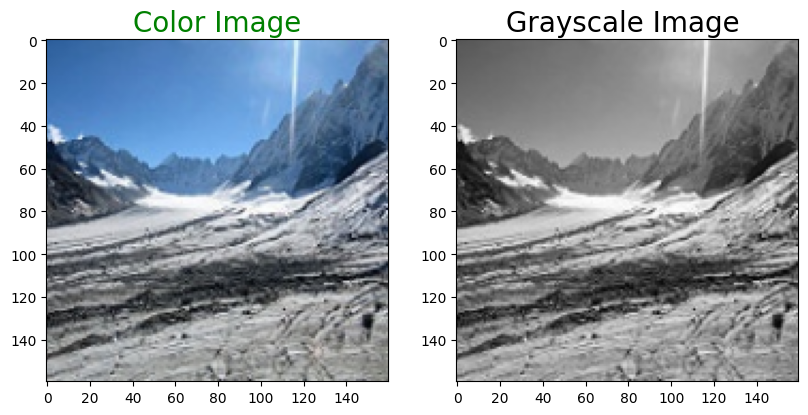

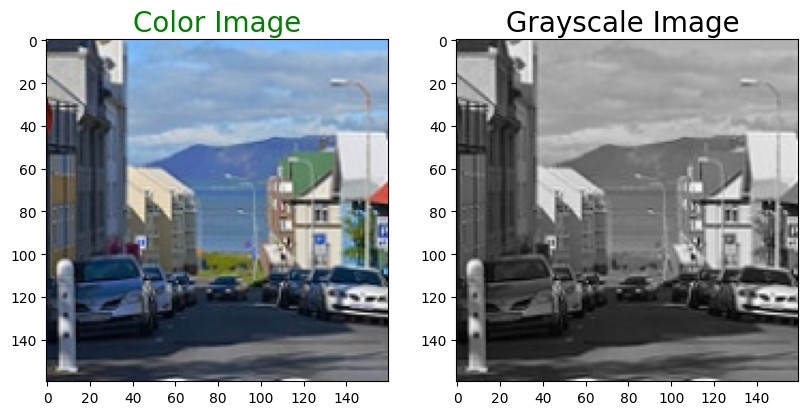

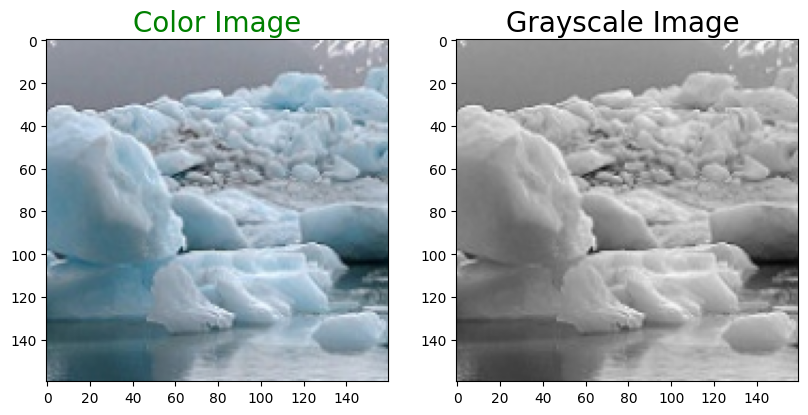

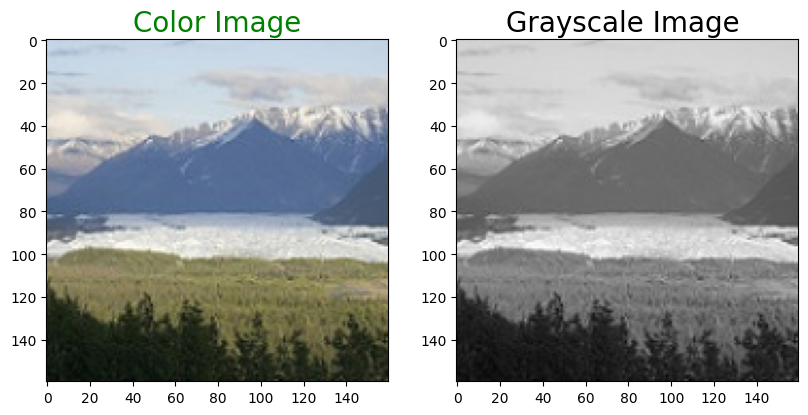

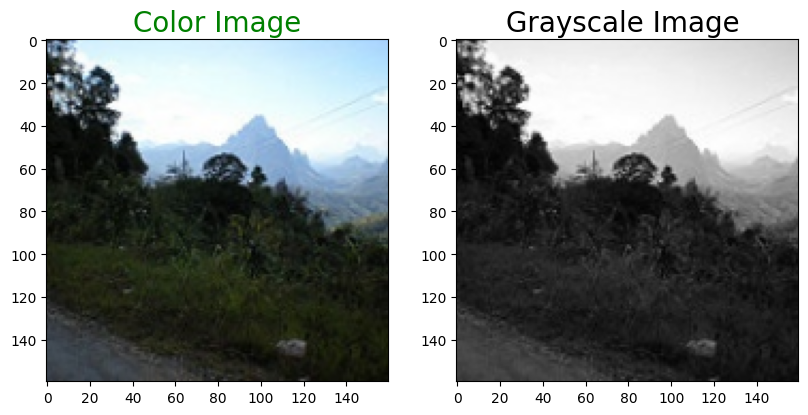

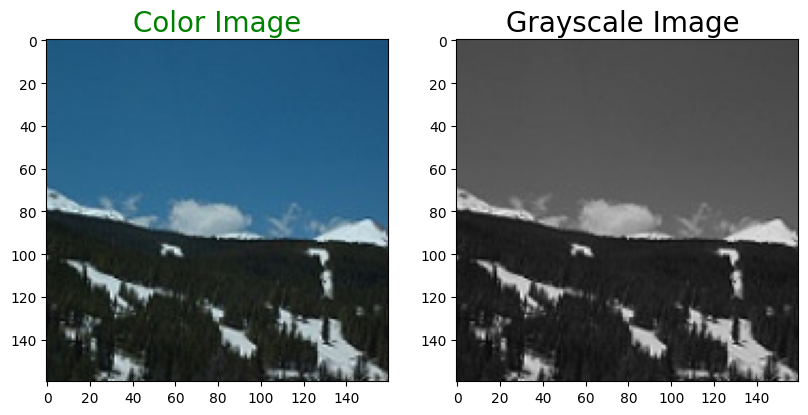

In [4]:
for i in range(3,10):
     plot_images_2(color_img[i],gray_img[i])

In [5]:
train_gray_image = gray_img[:4000]
train_color_image = color_img[:4000]

test_gray_image = gray_img[4000:]
test_color_image = color_img[4000:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (4000, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [7]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])

    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [8]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

history = model.fit(train_g, train_c, epochs = 120,steps_per_epoch=32,batch_size = 30,verbose = 1,validation_data=(test_gray_image,test_color_image))

Epoch 1/120
32/32 [==============================] - 22s 270ms/step - loss: 0.3282 - acc: 0.3417 - val_loss: 0.1373 - val_acc: 0.3541
Epoch 2/120
32/32 [==============================] - 6s 184ms/step - loss: 0.0988 - acc: 0.3588 - val_loss: 0.0884 - val_acc: 0.4135
Epoch 3/120
32/32 [==============================] - 6s 194ms/step - loss: 0.0824 - acc: 0.3864 - val_loss: 0.0831 - val_acc: 0.3634
Epoch 4/120
32/32 [==============================] - 6s 187ms/step - loss: 0.0767 - acc: 0.4171 - val_loss: 0.0782 - val_acc: 0.2304
Epoch 5/120
32/32 [==============================] - 9s 293ms/step - loss: 0.0731 - acc: 0.4132 - val_loss: 0.0752 - val_acc: 0.3409
Epoch 6/120
32/32 [==============================] - 6s 185ms/step - loss: 0.0677 - acc: 0.4313 - val_loss: 0.0707 - val_acc: 0.3322
Epoch 7/120
32/32 [==============================] - 6s 188ms/step - loss: 0.0660 - acc: 0.4439 - val_loss: 0.0706 - val_acc: 0.2909
Epoch 8/120
32/32 [==============================] - 6s 182ms/step -

In [10]:
model.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 3s 59ms/step - loss: 0.0469 - acc: 0.5316


[0.046907730400562286, 0.5316140651702881]

1/1 [==============================] - 0s 19ms/step


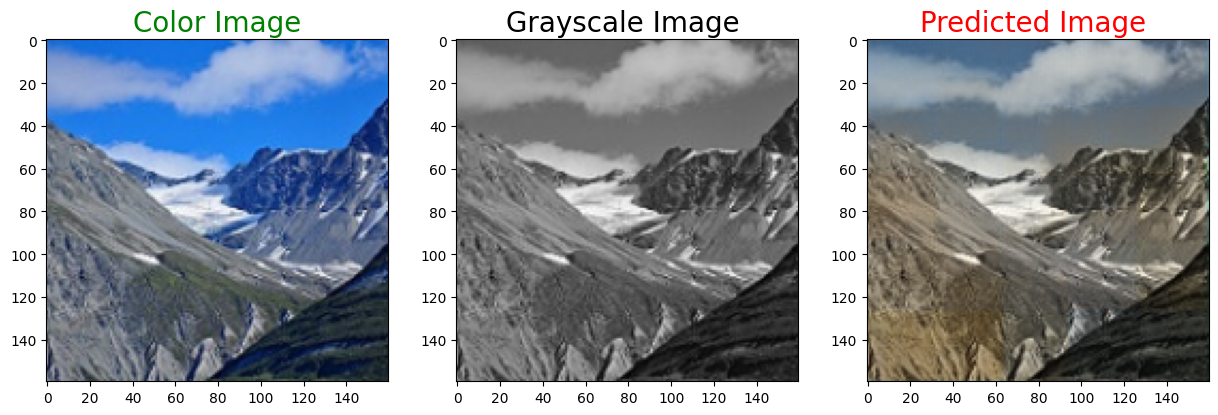

1/1 [==============================] - 0s 32ms/step


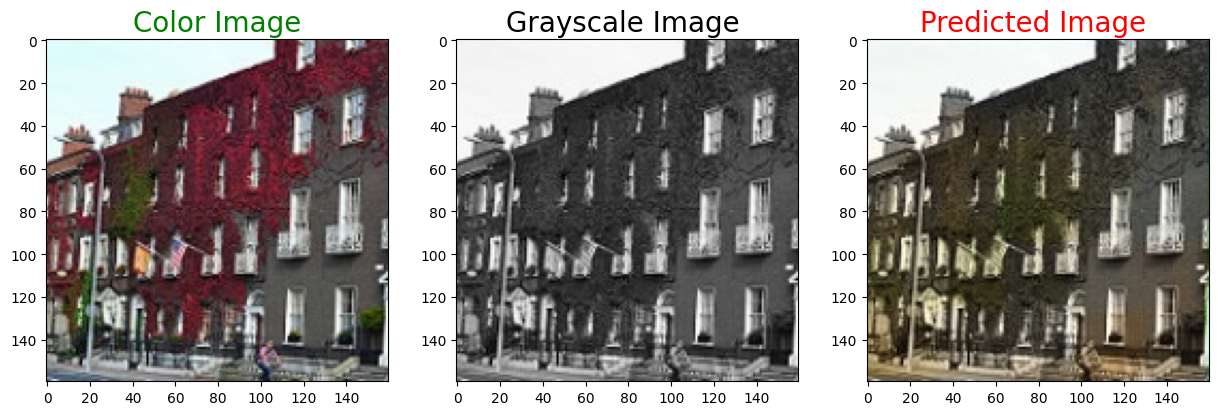

1/1 [==============================] - 0s 28ms/step


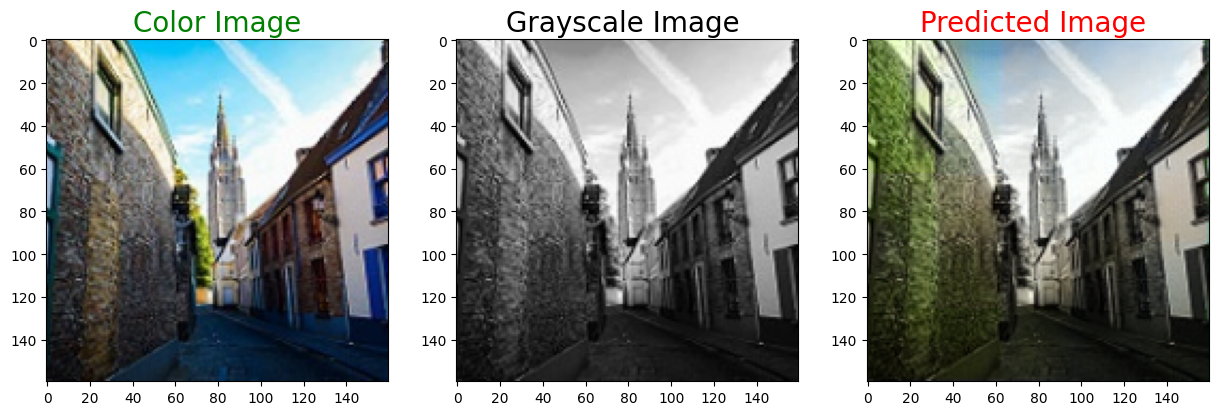

1/1 [==============================] - 0s 26ms/step


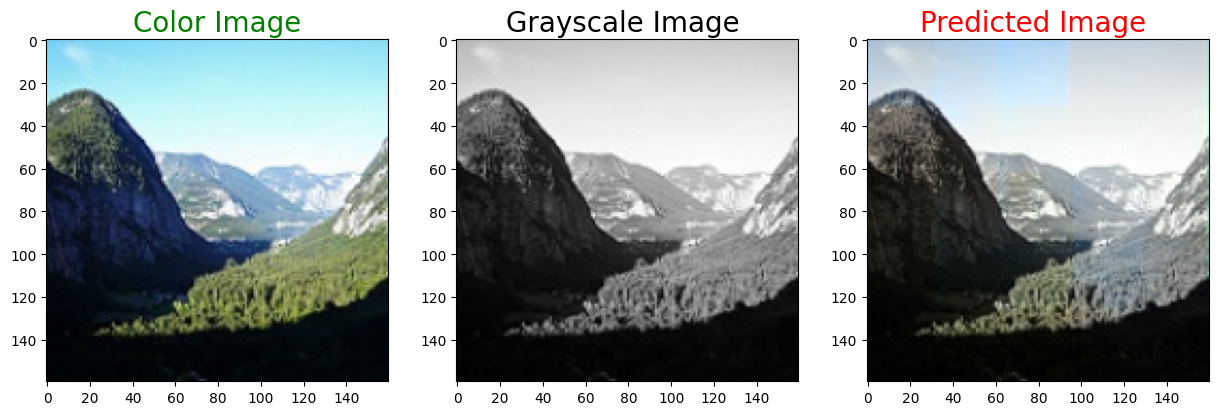

1/1 [==============================] - 0s 26ms/step


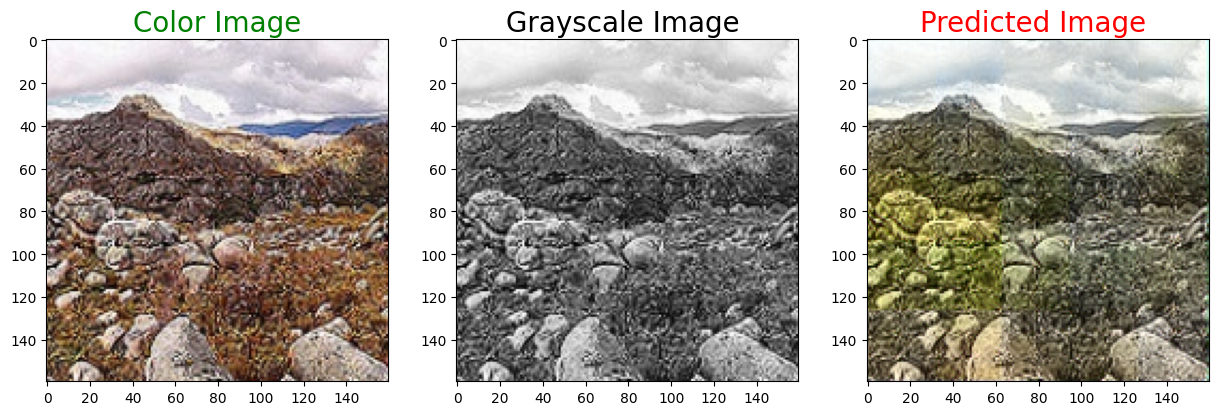

In [14]:
def plot_images_3(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(10,15):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images_3(test_color_image[i],test_gray_image[i],predicted)

In [12]:
model_json = model.to_json()

with open("model_opt.json","w") as json_file:
  json_file.write(model_json)

model.save_weights("model_opt.h5")

In [13]:
from keras.models import model_from_json
json_file = open('model_opt.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_opt.h5")

In [13]:
loaded_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

history = model.fit(train_g, train_c, epochs = 30,batch_size = 30,verbose = 1,validation_data=(test_gray_image,test_color_image))

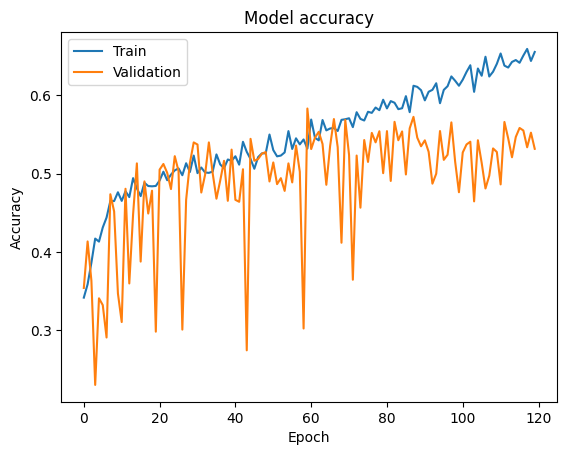

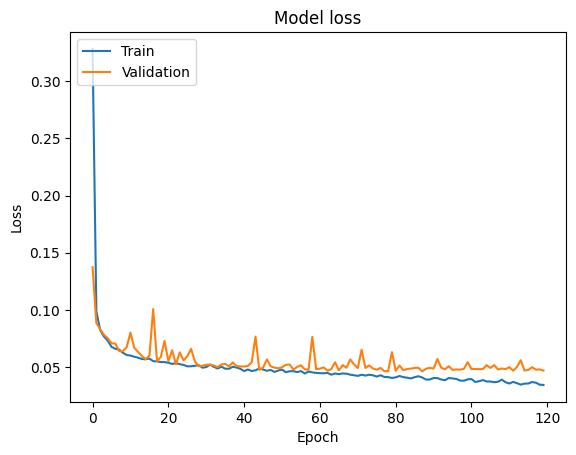

In [13]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_history(history)